Liam Campbell - July 2017

# Digit Recognition
* In this notebook I'll be training predictive models to classify handwriten digits.
* The data I will be using is from the MNIST dataset.

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

## Load and Explore Data

In [3]:
train_df = pd.read_csv('data/train.csv')

X = train_df.drop('label', axis=1)
y = train_df.label

train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


#### Check distribution of counts for different digits:

('Min/Max % Difference: ', 18.979504696840308)


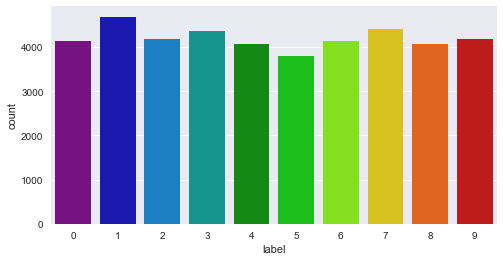

In [4]:
plt.figure(figsize=(8,4))

sns.countplot(x='label', data=train_df, palette='spectral')

label_counts = train_df.label.value_counts()
print ('Min/Max % Difference: ', 100*(1 - (label_counts.min() / float(label_counts.max()))))

Label counts are pretty evenly distributed. The least frequent digit is only around **19% less present** in the training set than the most frequent one. So we won't have to worry about adjusting for class frequency.

#### Check for missingness:

In [5]:
print('No missing values: ', not train_df.isnull().values.any())

('No missing values: ', True)


What a suprise. 

## Simple Cluster Analysis
* Intital cluster analysis to see how well-seperated our digit classes are.

<IPython.core.display.Javascript object>


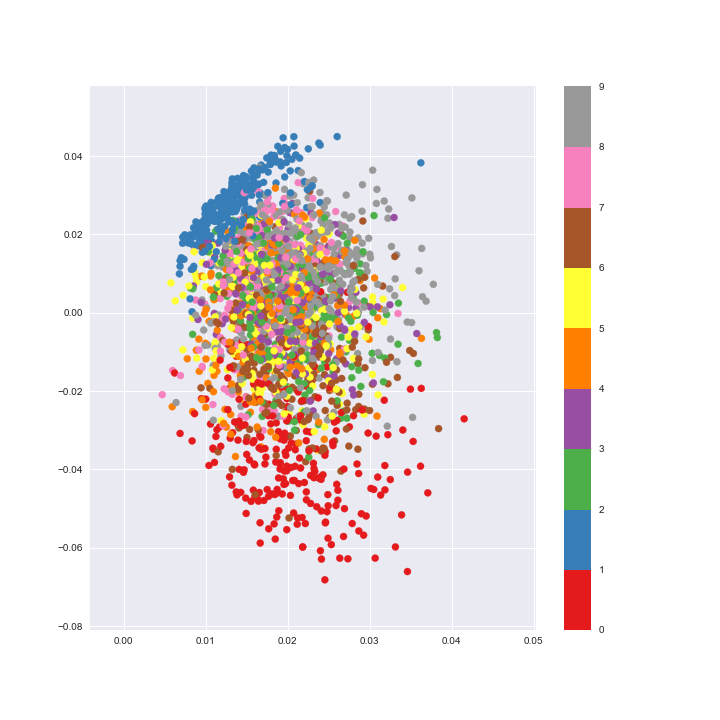

In [63]:
# Reduce data to two dimenstions using PCA decomposition

pca_2d = PCA(n_components=2)
pca_2d.fit(X[:2500].transpose())
reduced_2d = pd.DataFrame(pca_2d.components_.transpose())

reduced_2d.columns = ['x', 'y']
reduced_2d['label'] = y

plt.figure(figsize=(10, 10))
plt.scatter(reduced_2d.x, reduced_2d.y, c=reduced_2d.label, s=50, cmap='Set1')
plt.colorbar()

From this visualization of the 2-dimensional deccomposition of our data, it appears that some more uniquely strucured digits, such as 0 and 1, are in well-separaed clusters. However, the clusters of less uniquely structured digits, such as 8 and 9, have some significant overlap. Let's try to plot a 3-dimensional decomposition of the data to see if we can get some better seperation.

<IPython.core.display.Javascript object>


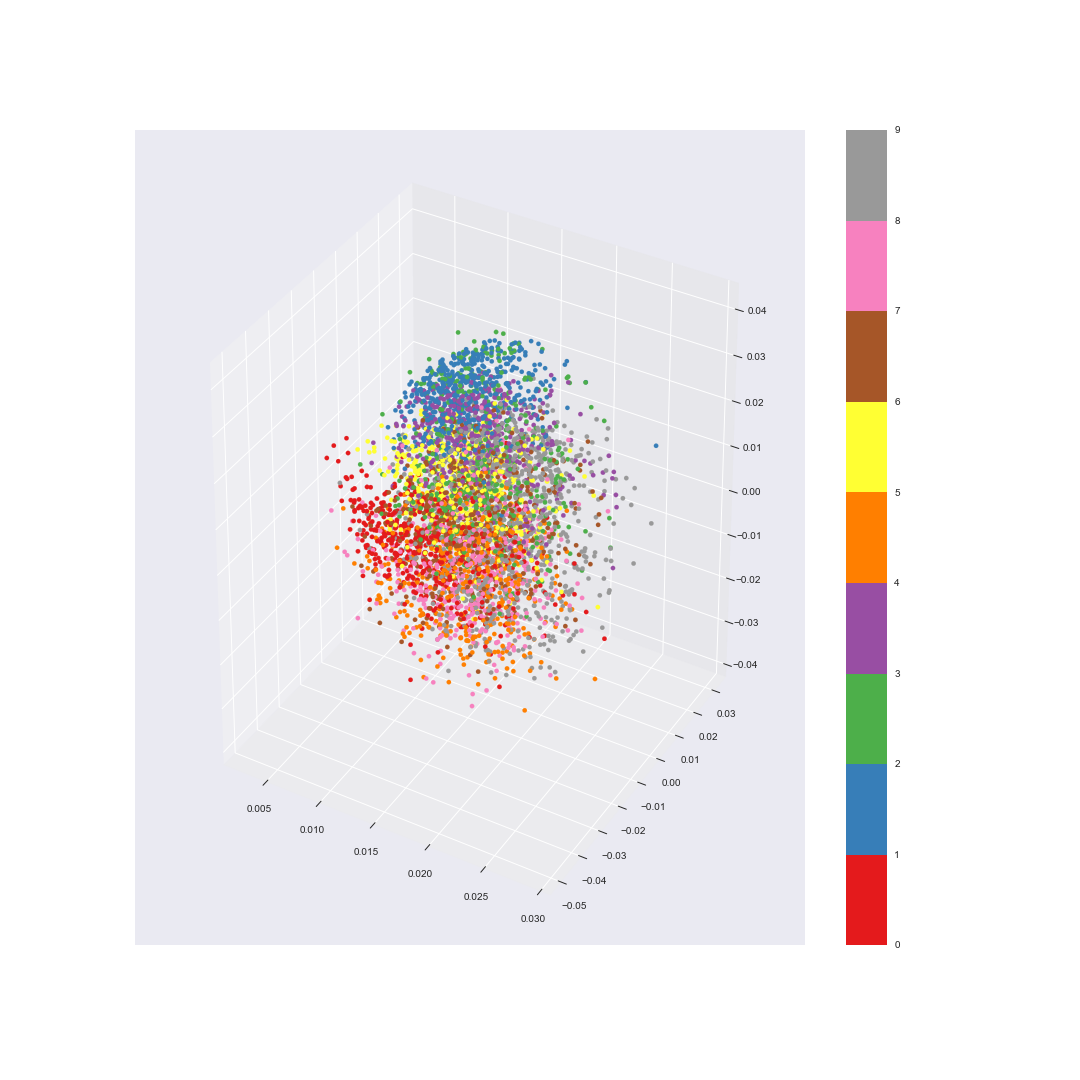

In [64]:
pca_3d = PCA(n_components=3)
pca_3d.fit(X[:5000].transpose())
reduced_3d = pd.DataFrame(pca_3d.components_.transpose())

reduced_3d.columns = ['x', 'y', 'z']
reduced_3d['label'] = y

%matplotlib notebook
fig = plt.figure()
plt.rcParams['figure.figsize']=(15,15)
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(reduced_3d['x'], reduced_3d['y'], reduced_3d['z'], c=reduced_3d['label'], cmap='Set1')
fig.colorbar(p)

In this 3-dimensional visualization some digits' cluster still overlap, but there are somewhat clearer distinctions between all clusters when compared to the 2-dimensional case. Let's check the explained variance curve for PCA on our dataset:

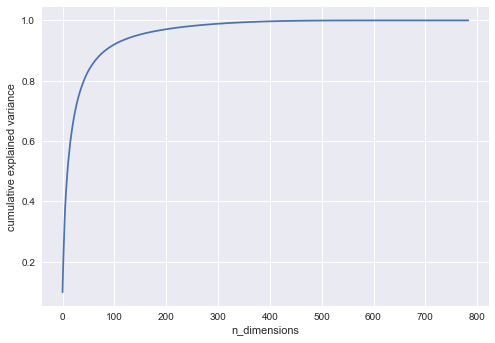

In [7]:
# Check explained variance curve for dataset

pca = PCA().fit(X[:2500])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('n_dimensions')
plt.ylabel('cumulative explained variance')

Here we can see that we start to lose a significant amount of information as we reduce to below 50 dimensions. Let's try a manifold technique since our data seams to be non-linear.

In [8]:
# Reduce dimensionality of data using isometric mapping

isomap = Isomap(n_components=2)
isomap_2d = pd.DataFrame(isomap.fit_transform(X[:3000]))

isomap_2d.columns = ['x', 'y']
isomap_2d['label'] = y[:3000]

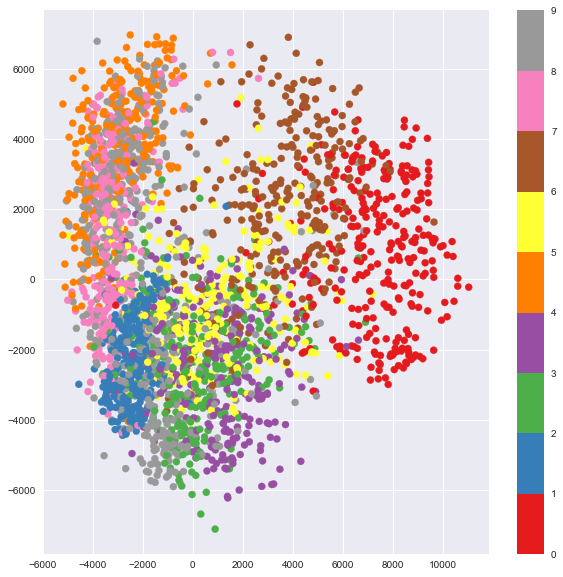

In [9]:
plt.figure(figsize=(10, 10))
plt.scatter(isomap_2d.x, isomap_2d.y, c=isomap_2d.label, s=50, cmap='Set1')
plt.colorbar()

In [10]:
isomap = Isomap(n_components=3)
isomap_3d = pd.DataFrame(isomap.fit_transform(X[:2000]))

isomap_3d.columns = ['x', 'y', 'z']
isomap_3d['label'] = y[:2000]

<IPython.core.display.Javascript object>


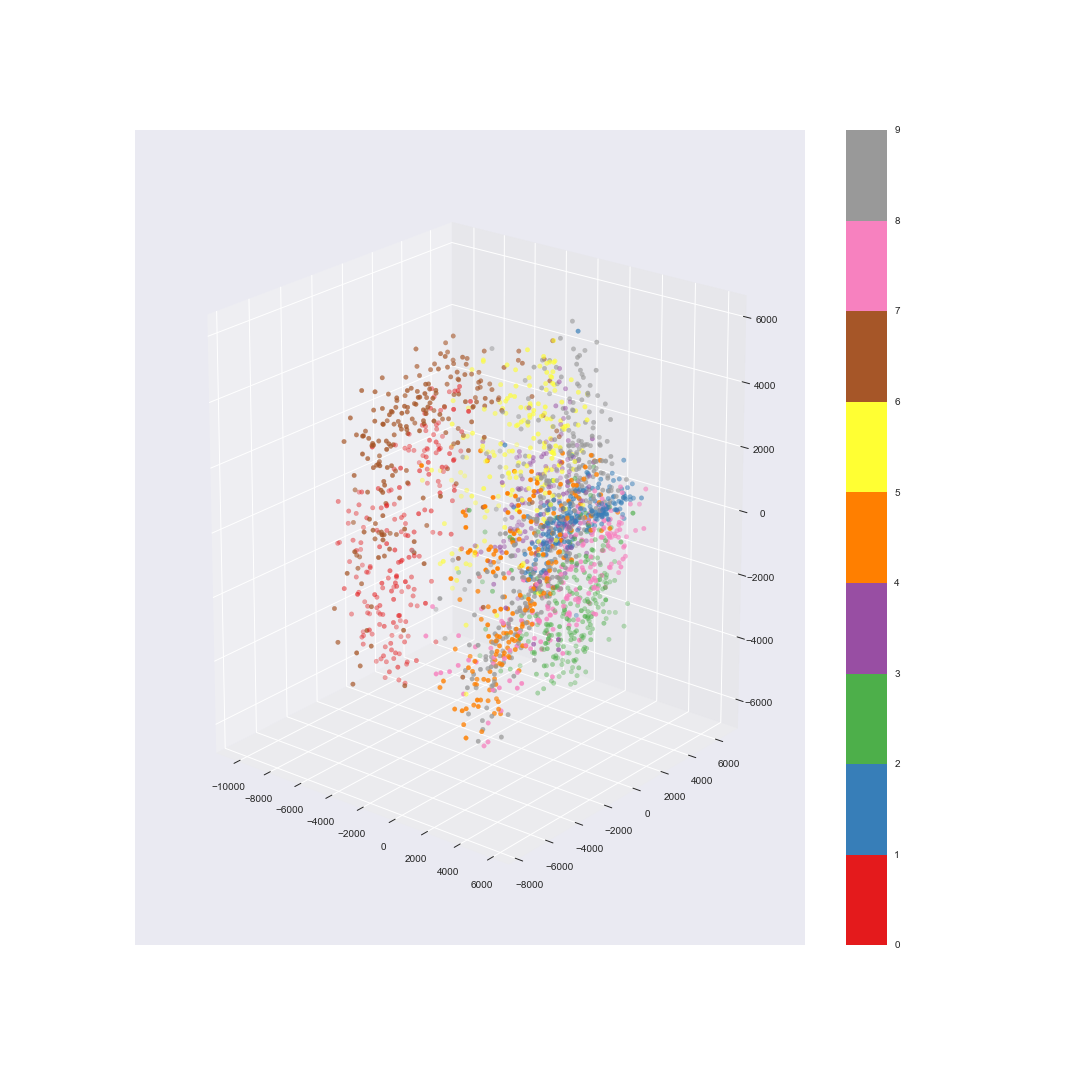

In [12]:
%matplotlib notebook
fig = plt.figure()
plt.rcParams['figure.figsize']=(15,15)
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(isomap_3d['x'], isomap_3d['y'], isomap_3d['z'], c=isomap_3d['label'], cmap='Set1')
fig.colorbar(p)

The digits' clusters are far better seperated when we use isometric mapping. This tells us that the data associated with the structure of the digits is non-linear. Also, by comparing the 2-d and 3-d plots we (and thus a machine learning model) can better differentiate between digits with each additional dimension we preserve in our decomposition of the original 785. We'll detrimine exactly how many dimensions we want to use in **model-classification** notebook. 